<a href="https://colab.research.google.com/github/AIWintermuteAI/aXeleRate/blob/dev/resources/aXeleRate_mark_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## M.A.R.K. Detection model Training and Inference

In this notebook we will use axelerate, Keras-based framework for AI on the edge, to quickly setup model training and then after training session is completed convert it to .tflite and .kmodel formats.

First, let's take care of some administrative details. 

1) Before we do anything, make sure you have choosen GPU as Runtime type (in Runtime - > Change Runtime type).

2) We need to mount Google Drive for saving our model checkpoints and final converted model(s). Press on Mount Google Drive button in Files tab on your left. 

In the next cell we clone axelerate Github repository and import it. 

**It is possible to use pip install or python setup.py install, but in that case you will need to restart the enironment.** Since I'm trying to make the process as streamlined as possibile I'm using sys.path.append for import.

In [1]:
import os
import flamegraph

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
os.environ["PER_PROCESS_GPU_MEMORY_FRACTION"]="0.7"
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext tensorboard
%load_ext autoreload
%autoreload 2
#we need imgaug 0.4 for image augmentations to work properly, see https://stackoverflow.com/questions/62580797/in-colab-doing-image-data-augmentation-with-imgaug-is-not-working-as-intended
#pip uninstall -y imgaug && pip uninstall -y albumentations && pip install imgaug==0.4
#git clone https://github.com/AIWintermuteAI/aXeleRate.git
import sys
import os

sys.path.append(os.path.join(os.getcwd(), '../'))
dataroot = os.path.join(os.getcwd(), '../../', 'telraam-model', 'data')
from axelerate import setup_training, setup_inference

At this step you typically need to get the dataset. You can use !wget command to download it from somewhere on the Internet or !cp to copy from My Drive as in this example
```
!cp -r /content/drive/'My Drive'/pascal_20_segmentation.zip .
!unzip --qq pascal_20_segmentation.zip
```
Dataset preparation and postprocessing are discussed in the article here:

The annotation tool I use is LabelImg
https://github.com/tzutalin/labelImg

Let's visualize our detection model test dataset. There are images in validation folder with corresponding annotations in PASCAL-VOC format in validation annotations folder.


/home/kervel/.cache/pypoetry/virtualenvs/axelerate-5llSWmvb-py3.8/lib/python3.8/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


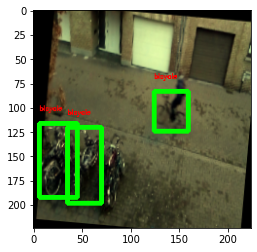

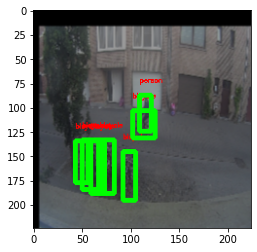

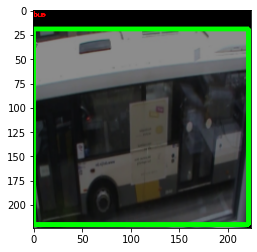

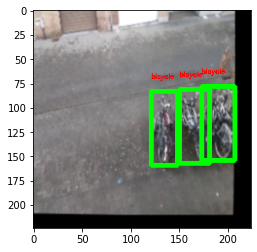

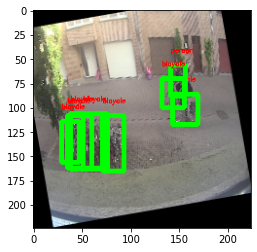

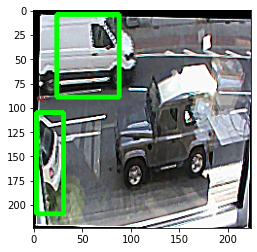

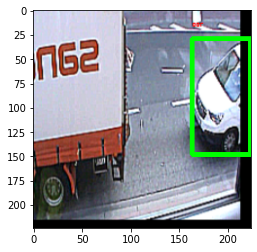

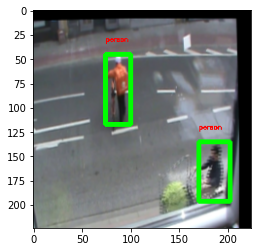

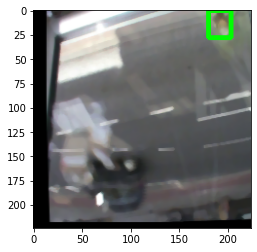

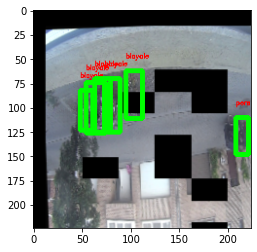

In [2]:
%matplotlib inline
#!gdown https://drive.google.com/uc?id=1s2h6DI_1tHpLoUWRc_SavvMF9jYG8XSi #dataset
#!gdown https://drive.google.com/uc?id=1-bDRZ9Z2T81SfwhHEfZIMFG7FtMQ5ZiZ #pre-trained model

#!unzip --qq mark_dataset.zip

from axelerate.networks.common_utils.augment import visualize_detection_dataset

visualize_detection_dataset(img_folder=os.path.join(dataroot), 
                            ann_folder=os.path.join(dataroot,'processed/telraam_data/train_annotations'), 
                            num_imgs=10, img_size=224, augment=True)

Next step is defining a config dictionary. Most lines are self-explanatory.

Type is model frontend - Classifier, Detector or Segnet

Architecture is model backend (feature extractor) 

- Full Yolo
- Tiny Yolo
- MobileNet1_0
- MobileNet7_5 
- MobileNet5_0 
- MobileNet2_5 
- SqueezeNet
- NASNetMobile
- DenseNet121
- ResNet50

For more information on anchors, please read here
https://github.com/pjreddie/darknet/issues/568

Labels are labels present in your dataset.
IMPORTANT: Please, list all the labels present in the dataset.

object_scale determines how much to penalize wrong prediction of confidence of object predictors

no_object_scale determines how much to penalize wrong prediction of confidence of non-object predictors

coord_scale determines how much to penalize wrong position and size predictions (x, y, w, h)

class_scale determines how much to penalize wrong class prediction

For converter type you can choose the following:

'k210', 'tflite_fullint', 'tflite_dynamic', 'edgetpu', 'openvino', 'onnx'


## Parameters for Person Detection

K210, which is where we will run the network, has constrained memory (5.5 RAM) available, so with Micropython firmware, the largest model you can run is about 2 MB, which limits our architecture choice to Tiny Yolo, MobileNet(up to 0.75 alpha) and SqueezeNet. Out of these 3 architectures, only one comes with pre-trained model - MobileNet. So, to save the training time we will use Mobilenet with alpha 0.75, which has ... parameters. For objects that do not have that much variety, you can use MobileNet with lower alpha, down to 0.25.

In [11]:
config = {
        "model":{
            "type":                 "Detector",
            "architecture":         "MobileNet5_0",
            "input_size":           224,
            "anchors":              [0.29,0.89, 0.46,1.58, 0.73,0.89, 1.04,2.28, 3.03,3.02],
            "labels":               ["bicycle", "car", "motorcycle", "person", "truck", "bus"],
            "coord_scale" : 		1.0,
            "class_scale" : 		1.0,
            "object_scale" : 		5.0,
            "no_object_scale" : 	1.0
        },
        "weights" : {
            "full":   				"",
            "backend":   		    "imagenet"
        },
        "train" : {
            "actual_epoch":         200,
            "train_image_folder":   dataroot,
            "train_annot_folder":   os.path.join(dataroot,'processed/telraam_data/train_annotations'),
            "train_times":          1,
            "valid_image_folder":   dataroot,
            "valid_annot_folder":   os.path.join(dataroot,'processed/telraam_data/val_annotations'),
            "valid_times":          1,
            "valid_metric":         "mAP",
            "batch_size":           80,
            "learning_rate":        1e-3,
            "saved_folder":   		os.path.join(os.getcwd(), "../out"),
            "first_trainable_layer": "",
            "augumentation":				True,
            "is_only_detect" : 		False
        },
        "converter" : {
            "type":   				["k210","tflite"]
        }
    }

Let's check what GPU we have been assigned in this Colab session, if any.

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13755650847318946162,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6413575776
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12750875445365643467
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:09:00.0, compute capability: 8.6"]

Also, let's open Tensorboard, where we will be able to watch model training progress in real time. Training and validation logs also will be saved in project folder.
Since there are no logs before we start the training, tensorboard will be empty. Refresh it after first epoch.

In [5]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6007 (pid 1325656), started 0:01:36 ago. (Use '!kill 1325656' to kill it.)

Finally we start the training by passing config dictionary we have defined earlier to setup_training function. The function will start the training with Checkpoint, Reduce Learning Rate on Plateau and Early Stopping callbacks. After the training has stopped, it will convert the best model into the format you have specified in config and save it to the project folder.

In [12]:
t = flamegraph.start_profile_thread(fd=open("./perf2.log", "w"))
from keras import backend as K 
K.clear_session()
try:
    model_path = setup_training(config_dict=config)
finally:
    t.stop()

Project folder /home/kervel/projects/telraam/aXeleRate/resources/../out already exists. Creating a folder for new training session.
Tflite Converter ready
K210 Converter ready
['bicycle', 'car', 'motorcycle', 'person', 'truck', 'bus']
Successfully loaded imagenet backend weights
Failed to load pre-trained weights for the whole model. It might be because you didn't specify any or the weight file cannot be found
Current training session folder is /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00


Model: "yolo"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 16)      432    

/home/kervel/.cache/pypoetry/virtualenvs/axelerate-5llSWmvb-py3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/home/kervel/.cache/pypoetry/virtualenvs/axelerate-5llSWmvb-py3.8/lib/python3.8/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Epoch 1/200
200/200 [==============================] - 98s 471ms/step - loss: 20.7503 - val_loss: 12.1732


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


/home/kervel/projects/telraam/aXeleRate/resources/../axelerate/networks/yolo/backend/batch_gen.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return imgs_list, np.array(anns_list)
100%|██████████| 50/50 [01:00<00:00,  1.21s/it]

End calc mAP


bicycle 0.0000
car 0.0000
motorcycle 0.0000
person 0.0000
truck 0.0000
bus 0.0000
mAP: 0.0000
Saving model on first epoch irrespective of mAP
Epoch 00000: Learning rate is 0.0003316666666666667.

Epoch 2/200


200/200 [==============================] - 96s 468ms/step - loss: 19.7733 - val_loss: 12.9657


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:10<00:00,  4.66it/s]


End calc mAP


bicycle 0.0000
car 0.0000
motorcycle 0.0000
person 0.0000
truck 0.0000
bus 0.0000
mAP: 0.0000
mAP did not improve from 0.
Epoch 00001: Learning rate is 0.000665.

Epoch 3/200
200/200 [==============================] - 95s 467ms/step - loss: 18.7203 - val_loss: 13.0409


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:09<00:00,  5.03it/s]


End calc mAP


bicycle 0.0314
car 0.1666
motorcycle 0.0000
person 0.0000
truck 0.0000
bus 0.0000
mAP: 0.0330
mAP improved from 0 to 0.03299862705766724, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00002: Learning rate is 0.0009983333333333333.

Epoch 4/200
200/200 [==============================] - 96s 471ms/step - loss: 19.3152 - val_loss: 12.8954


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


End calc mAP


bicycle 0.0523
car 0.4358
motorcycle 0.0000
person 0.0000
truck 0.0000
bus 0.0000
mAP: 0.0814
mAP improved from 0.03299862705766724 to 0.08135838353446419, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00003: Learning rate is 0.0009999370574474513.

Epoch 5/200
200/200 [==============================] - 96s 474ms/step - loss: 18.8810 - val_loss: 12.7507


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


End calc mAP


bicycle 0.1557
car 0.5612
motorcycle 0.0000
person 0.0000
truck 0.0000
bus 0.0000
mAP: 0.1195
mAP improved from 0.08135838353446419 to 0.11948661876480882, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00004: Learning rate is 0.0009997469790570877.

Epoch 6/200
200/200 [==============================] - 96s 469ms/step - loss: 18.7600 - val_loss: 12.7052


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:10<00:00,  4.61it/s]


End calc mAP


bicycle 0.1003
car 0.5905
motorcycle 0.0000
person 0.0000
truck 0.0000
bus 0.0000
mAP: 0.1151
mAP did not improve from 0.11948661876480882.
Epoch 00005: Learning rate is 0.000999429811577698.

Epoch 7/200
200/200 [==============================] - 96s 470ms/step - loss: 18.2734 - val_loss: 12.7278


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


End calc mAP


bicycle 0.1022
car 0.6084
motorcycle 0.0000
person 0.0000
truck 0.0000
bus 0.0196
mAP: 0.1217
mAP improved from 0.11948661876480882 to 0.12170127574223878, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00006: Learning rate is 0.0009989856356671504.

Epoch 8/200
200/200 [==============================] - 96s 471ms/step - loss: 18.4295 - val_loss: 12.7064


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


End calc mAP


bicycle 0.1299
car 0.6689
motorcycle 0.0000
person 0.0000
truck 0.0000
bus 0.0784
mAP: 0.1462
mAP improved from 0.12170127574223878 to 0.146194430927721, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00007: Learning rate is 0.0009984145642824298.

Epoch 9/200
200/200 [==============================] - 96s 469ms/step - loss: 19.7953 - val_loss: 12.7075


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:10<00:00,  4.65it/s]


End calc mAP


bicycle 0.1307
car 0.6925
motorcycle 0.0000
person 0.0000
truck 0.0000
bus 0.0588
mAP: 0.1470
mAP improved from 0.146194430927721 to 0.1470090832754457, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00008: Learning rate is 0.0009977167426509109.

Epoch 10/200
200/200 [==============================] - 96s 469ms/step - loss: 18.5393 - val_loss: 12.7694


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:10<00:00,  4.67it/s]


End calc mAP


bicycle 0.1024
car 0.6770
motorcycle 0.0000
person 0.0012
truck 0.0000
bus 0.0098
mAP: 0.1317
mAP did not improve from 0.1470090832754457.
Epoch 00009: Learning rate is 0.0009968923482334276.

Epoch 11/200
200/200 [==============================] - 96s 471ms/step - loss: 18.5788 - val_loss: 12.7193


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.50it/s]


End calc mAP


bicycle 0.1370
car 0.6931
motorcycle 0.0000
person 0.0011
truck 0.0000
bus 0.0196
mAP: 0.1418
mAP did not improve from 0.1470090832754457.
Epoch 00010: Learning rate is 0.000995941590679142.

Epoch 12/200
200/200 [==============================] - 96s 470ms/step - loss: 18.8406 - val_loss: 12.6139


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


End calc mAP


bicycle 0.1570
car 0.7114
motorcycle 0.0000
person 0.0019
truck 0.0000
bus 0.0203
mAP: 0.1484
mAP improved from 0.1470090832754457 to 0.14842941132725626, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00011: Learning rate is 0.0009948647117722302.

Epoch 13/200
200/200 [==============================] - 97s 473ms/step - loss: 18.9527 - val_loss: 12.6283


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


End calc mAP


bicycle 0.1386
car 0.7116
motorcycle 0.0000
person 0.0081
truck 0.0000
bus 0.0553
mAP: 0.1523
mAP improved from 0.14842941132725626 to 0.15227759841331048, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00012: Learning rate is 0.000993661985370394.

Epoch 14/200
200/200 [==============================] - 96s 468ms/step - loss: 18.3141 - val_loss: 12.5672


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]


End calc mAP


bicycle 0.0939
car 0.6558
motorcycle 0.0000
person 0.0040
truck 0.0000
bus 0.1644
mAP: 0.1530
mAP improved from 0.15227759841331048 to 0.15299977826851907, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00013: Learning rate is 0.0009923337173352177.

Epoch 15/200
200/200 [==============================] - 97s 477ms/step - loss: 18.2765 - val_loss: 12.6591


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.15it/s]


End calc mAP


bicycle 0.1566
car 0.7701
motorcycle 0.0000
person 0.0025
truck 0.0000
bus 0.1842
mAP: 0.1856
mAP improved from 0.15299977826851907 to 0.185569277827782, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00014: Learning rate is 0.0009908802454543853.

Epoch 16/200
200/200 [==============================] - 99s 484ms/step - loss: 19.0530 - val_loss: 12.6373


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


End calc mAP


bicycle 0.1493
car 0.7639
motorcycle 0.0000
person 0.0152
truck 0.0000
bus 0.1373
mAP: 0.1776
mAP did not improve from 0.185569277827782.
Epoch 00015: Learning rate is 0.0009893019393557782.

Epoch 17/200
200/200 [==============================] - 97s 475ms/step - loss: 19.2320 - val_loss: 12.5896


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


End calc mAP


bicycle 0.1512
car 0.7157
motorcycle 0.0000
person 0.0118
truck 0.0000
bus 0.2904
mAP: 0.1948
mAP improved from 0.185569277827782 to 0.19484476701947448, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00016: Learning rate is 0.0009875992004134775.

Epoch 18/200
200/200 [==============================] - 97s 474ms/step - loss: 19.2472 - val_loss: 12.6200


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.16it/s]


End calc mAP


bicycle 0.1284
car 0.6658
motorcycle 0.0000
person 0.0119
truck 0.0000
bus 0.3333
mAP: 0.1899
mAP did not improve from 0.19484476701947448.
Epoch 00017: Learning rate is 0.0009857724616456902.

Epoch 19/200
200/200 [==============================] - 96s 472ms/step - loss: 19.0291 - val_loss: 12.7027


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


End calc mAP


bicycle 0.1814
car 0.7327
motorcycle 0.0000
person 0.0160
truck 0.0000
bus 0.1460
mAP: 0.1793
mAP did not improve from 0.19484476701947448.
Epoch 00018: Learning rate is 0.0009838221876046311.

Epoch 20/200
200/200 [==============================] - 97s 475ms/step - loss: 19.2344 - val_loss: 12.6079


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


End calc mAP


bicycle 0.1171
car 0.7210
motorcycle 0.0000
person 0.0151
truck 0.0000
bus 0.2286
mAP: 0.1803
mAP did not improve from 0.19484476701947448.
Epoch 00019: Learning rate is 0.0009817488742583835.

Epoch 21/200
200/200 [==============================] - 96s 469ms/step - loss: 20.1786 - val_loss: 12.7035


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


End calc mAP


bicycle 0.1100
car 0.6730
motorcycle 0.0000
person 0.0154
truck 0.0000
bus 0.1458
mAP: 0.1574
mAP did not improve from 0.19484476701947448.
Epoch 00020: Learning rate is 0.0009795530488647705.

Epoch 22/200
200/200 [==============================] - 97s 473ms/step - loss: 18.5974 - val_loss: 12.6221


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.13it/s]


End calc mAP


bicycle 0.1768
car 0.7731
motorcycle 0.0000
person 0.0239
truck 0.0000
bus 0.1820
mAP: 0.1926
mAP did not improve from 0.19484476701947448.
Epoch 00021: Learning rate is 0.0009772352698372707.

Epoch 23/200
200/200 [==============================] - 97s 473ms/step - loss: 18.4601 - val_loss: 12.5931


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  3.85it/s]


End calc mAP


bicycle 0.1601
car 0.7775
motorcycle 0.0000
person 0.0142
truck 0.0000
bus 0.1305
mAP: 0.1804
mAP did not improve from 0.19484476701947448.
Epoch 00022: Learning rate is 0.0009747961266030092.

Epoch 24/200
200/200 [==============================] - 97s 475ms/step - loss: 18.6982 - val_loss: 12.6413


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  3.93it/s]


End calc mAP


bicycle 0.1199
car 0.7620
motorcycle 0.0000
person 0.0246
truck 0.0000
bus 0.1488
mAP: 0.1759
mAP did not improve from 0.19484476701947448.
Epoch 00023: Learning rate is 0.0009722362394528626.

Epoch 25/200
200/200 [==============================] - 96s 467ms/step - loss: 18.2487 - val_loss: 12.6158


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.46it/s]


End calc mAP


bicycle 0.1327
car 0.7415
motorcycle 0.0000
person 0.0214
truck 0.0000
bus 0.2155
mAP: 0.1852
mAP did not improve from 0.19484476701947448.
Epoch 00024: Learning rate is 0.0009695562593837144.

Epoch 26/200
200/200 [==============================] - 97s 474ms/step - loss: 18.6989 - val_loss: 12.6889


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.05it/s]


End calc mAP


bicycle 0.1493
car 0.7557
motorcycle 0.0000
person 0.0169
truck 0.0000
bus 0.1124
mAP: 0.1724
mAP did not improve from 0.19484476701947448.
Epoch 00025: Learning rate is 0.000966756867932902.

Epoch 27/200
200/200 [==============================] - 96s 466ms/step - loss: 19.0815 - val_loss: 12.6324


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


End calc mAP


bicycle 0.1224
car 0.7759
motorcycle 0.0000
person 0.0276
truck 0.0000
bus 0.2235
mAP: 0.1916
mAP did not improve from 0.19484476701947448.
Epoch 00026: Learning rate is 0.0009638387770048979.

Epoch 28/200
200/200 [==============================] - 96s 469ms/step - loss: 18.4241 - val_loss: 12.6952


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


End calc mAP


bicycle 0.1792
car 0.7770
motorcycle 0.0000
person 0.0237
truck 0.0000
bus 0.2149
mAP: 0.1991
mAP improved from 0.19484476701947448 to 0.19913712507298462, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00027: Learning rate is 0.0009608027286902661.

Epoch 29/200
200/200 [==============================] - 96s 467ms/step - loss: 18.7764 - val_loss: 12.6418


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


End calc mAP


bicycle 0.1668
car 0.7554
motorcycle 0.0000
person 0.0266
truck 0.0000
bus 0.3785
mAP: 0.2212
mAP improved from 0.19913712507298462 to 0.22119441897624478, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00028: Learning rate is 0.0009576494950769448.

Epoch 30/200
200/200 [==============================] - 97s 474ms/step - loss: 18.4384 - val_loss: 12.6210


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


End calc mAP


bicycle 0.1278
car 0.7808
motorcycle 0.0000
person 0.0234
truck 0.0000
bus 0.3411
mAP: 0.2122
mAP did not improve from 0.22119441897624478.
Epoch 00029: Learning rate is 0.000954379878053898.

Epoch 31/200
200/200 [==============================] - 96s 471ms/step - loss: 18.7052 - val_loss: 12.5957


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


End calc mAP


bicycle 0.1607
car 0.7544
motorcycle 0.0000
person 0.0232
truck 0.0000
bus 0.3587
mAP: 0.2162
mAP did not improve from 0.22119441897624478.
Epoch 00030: Learning rate is 0.0009509947091071905.

Epoch 32/200
200/200 [==============================] - 97s 471ms/step - loss: 18.3591 - val_loss: 12.5929


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.16it/s]


End calc mAP


bicycle 0.1854
car 0.7393
motorcycle 0.0000
person 0.0387
truck 0.0000
bus 0.3676
mAP: 0.2218
mAP improved from 0.22119441897624478 to 0.2218376996445818, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00031: Learning rate is 0.0009474948491085347.

Epoch 33/200
200/200 [==============================] - 96s 471ms/step - loss: 19.1571 - val_loss: 12.6097


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


End calc mAP


bicycle 0.1408
car 0.7627
motorcycle 0.0000
person 0.0402
truck 0.0000
bus 0.2630
mAP: 0.2011
mAP did not improve from 0.2218376996445818.
Epoch 00032: Learning rate is 0.0009438811880963651.

Epoch 34/200
200/200 [==============================] - 97s 472ms/step - loss: 17.8727 - val_loss: 12.5670


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


End calc mAP


bicycle 0.1844
car 0.7580
motorcycle 0.0000
person 0.0316
truck 0.0000
bus 0.2496
mAP: 0.2039
mAP did not improve from 0.2218376996445818.
Epoch 00033: Learning rate is 0.0009401546450494958.

Epoch 35/200
200/200 [==============================] - 97s 470ms/step - loss: 18.7029 - val_loss: 12.5707


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


End calc mAP


bicycle 0.1266
car 0.7787
motorcycle 0.0000
person 0.0280
truck 0.0000
bus 0.2660
mAP: 0.1999
mAP did not improve from 0.2218376996445818.
Epoch 00034: Learning rate is 0.0009363161676534172.

Epoch 36/200
200/200 [==============================] - 97s 473ms/step - loss: 18.5076 - val_loss: 12.5789


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


End calc mAP


bicycle 0.1869
car 0.7916
motorcycle 0.0000
person 0.0426
truck 0.0000
bus 0.3115
mAP: 0.2221
mAP improved from 0.2218376996445818 to 0.22210365597773732, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00035: Learning rate is 0.0009323667320592939.

Epoch 37/200
200/200 [==============================] - 97s 472ms/step - loss: 18.9583 - val_loss: 12.5464


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


End calc mAP


bicycle 0.2002
car 0.7973
motorcycle 0.0000
person 0.0544
truck 0.0000
bus 0.3063
mAP: 0.2264
mAP improved from 0.22210365597773732 to 0.22636605891152342, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00036: Learning rate is 0.0009283073426357223.

Epoch 38/200
200/200 [==============================] - 96s 471ms/step - loss: 18.1412 - val_loss: 12.5636


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.39it/s]


End calc mAP


bicycle 0.1857
car 0.7819
motorcycle 0.0000
person 0.0310
truck 0.0000
bus 0.3452
mAP: 0.2240
mAP did not improve from 0.22636605891152342.
Epoch 00037: Learning rate is 0.000924139031713312.

Epoch 39/200
200/200 [==============================] - 97s 474ms/step - loss: 18.6787 - val_loss: 12.6494


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


End calc mAP


bicycle 0.1649
car 0.8086
motorcycle 0.0000
person 0.0488
truck 0.0000
bus 0.2762
mAP: 0.2164
mAP did not improve from 0.22636605891152342.
Epoch 00038: Learning rate is 0.0009198628593221591.

Epoch 40/200
200/200 [==============================] - 96s 468ms/step - loss: 18.3388 - val_loss: 12.5906


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


End calc mAP


bicycle 0.1329
car 0.7832
motorcycle 0.0000
person 0.0356
truck 0.0000
bus 0.3669
mAP: 0.2198
mAP did not improve from 0.22636605891152342.
Epoch 00039: Learning rate is 0.0009154799129222713.

Epoch 41/200
200/200 [==============================] - 97s 475ms/step - loss: 18.3121 - val_loss: 12.5668


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.46it/s]


End calc mAP


bicycle 0.1591
car 0.8035
motorcycle 0.0000
person 0.0354
truck 0.0000
bus 0.2943
mAP: 0.2154
mAP did not improve from 0.22636605891152342.
Epoch 00040: Learning rate is 0.0009109913071270194.

Epoch 42/200
200/200 [==============================] - 97s 475ms/step - loss: 18.4236 - val_loss: 12.5876


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:13<00:00,  3.81it/s]


End calc mAP


bicycle 0.1714
car 0.7742
motorcycle 0.0000
person 0.0525
truck 0.0000
bus 0.3442
mAP: 0.2237
mAP did not improve from 0.22636605891152342.
Epoch 00041: Learning rate is 0.0009063981834196857.

Epoch 43/200
200/200 [==============================] - 97s 470ms/step - loss: 18.6904 - val_loss: 12.6425


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


End calc mAP


bicycle 0.1560
car 0.7246
motorcycle 0.0000
person 0.0484
truck 0.0000
bus 0.3018
mAP: 0.2051
mAP did not improve from 0.22636605891152342.
Epoch 00042: Learning rate is 0.0009017017098631736.

Epoch 44/200
200/200 [==============================] - 97s 473ms/step - loss: 18.6649 - val_loss: 12.5964


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.21it/s]


End calc mAP


bicycle 0.1743
car 0.8007
motorcycle 0.0000
person 0.0603
truck 0.0000
bus 0.3314
mAP: 0.2278
mAP improved from 0.22636605891152342 to 0.22778855229572495, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00043: Learning rate is 0.0008969030808029646.

Epoch 45/200
200/200 [==============================] - 97s 475ms/step - loss: 18.9854 - val_loss: 12.6627


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


End calc mAP


bicycle 0.1440
car 0.8002
motorcycle 0.0000
person 0.0478
truck 0.0000
bus 0.3458
mAP: 0.2230
mAP did not improve from 0.22778855229572495.
Epoch 00044: Learning rate is 0.000892003516563385.

Epoch 46/200
200/200 [==============================] - 97s 471ms/step - loss: 18.3198 - val_loss: 12.5562


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


End calc mAP


bicycle 0.1706
car 0.8033
motorcycle 0.0000
person 0.0503
truck 0.0000
bus 0.4171
mAP: 0.2402
mAP improved from 0.22778855229572495 to 0.2402221749488654, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00045: Learning rate is 0.0008870042631372712.

Epoch 47/200
200/200 [==============================] - 97s 473ms/step - loss: 18.2825 - val_loss: 12.5259


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:13<00:00,  3.76it/s]


End calc mAP


bicycle 0.1677
car 0.8080
motorcycle 0.0000
person 0.0573
truck 0.0000
bus 0.3614
mAP: 0.2324
mAP did not improve from 0.2402221749488654.
Epoch 00046: Learning rate is 0.0008819065918691043.

Epoch 48/200
200/200 [==============================] - 98s 476ms/step - loss: 19.0552 - val_loss: 12.5524


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.24it/s]


End calc mAP


bicycle 0.1668
car 0.7890
motorcycle 0.0000
person 0.0389
truck 0.0000
bus 0.4384
mAP: 0.2389
mAP did not improve from 0.2402221749488654.
Epoch 00047: Learning rate is 0.0008767117991316984.

Epoch 49/200
200/200 [==============================] - 98s 477ms/step - loss: 18.8349 - val_loss: 12.5375


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


End calc mAP


bicycle 0.2240
car 0.7931
motorcycle 0.0000
person 0.0414
truck 0.0000
bus 0.4389
mAP: 0.2496
mAP improved from 0.2402221749488654 to 0.24957443871439047, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00048: Learning rate is 0.0008714212059965246.

Epoch 50/200
200/200 [==============================] - 98s 475ms/step - loss: 18.4873 - val_loss: 12.5190


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


End calc mAP


bicycle 0.1504
car 0.8057
motorcycle 0.0000
person 0.0633
truck 0.0000
bus 0.4191
mAP: 0.2397
mAP did not improve from 0.24957443871439047.
Epoch 00049: Learning rate is 0.0008660361578977524.

Epoch 51/200
200/200 [==============================] - 97s 474ms/step - loss: 18.7269 - val_loss: 12.5139


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


End calc mAP


bicycle 0.1716
car 0.7854
motorcycle 0.0000
person 0.0667
truck 0.0000
bus 0.3983
mAP: 0.2370
mAP did not improve from 0.24957443871439047.
Epoch 00050: Learning rate is 0.0008605580242900982.

Epoch 52/200
200/200 [==============================] - 97s 472ms/step - loss: 18.5954 - val_loss: 12.6131


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.10it/s]


End calc mAP


bicycle 0.1634
car 0.8145
motorcycle 0.0000
person 0.0609
truck 0.0000
bus 0.4772
mAP: 0.2527
mAP improved from 0.24957443871439047 to 0.2526549990888275, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00051: Learning rate is 0.0008549881983005618.

Epoch 53/200
200/200 [==============================] - 98s 476ms/step - loss: 18.3341 - val_loss: 12.5980


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


End calc mAP


bicycle 0.1818
car 0.8062
motorcycle 0.0000
person 0.0653
truck 0.0000
bus 0.4388
mAP: 0.2487
mAP did not improve from 0.2526549990888275.
Epoch 00052: Learning rate is 0.0008493280963741461.

Epoch 54/200
200/200 [==============================] - 99s 480ms/step - loss: 19.0054 - val_loss: 12.5324


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


End calc mAP


bicycle 0.2034
car 0.8202
motorcycle 0.0000
person 0.0650
truck 0.0000
bus 0.3649
mAP: 0.2422
mAP did not improve from 0.2526549990888275.
Epoch 00053: Learning rate is 0.0008435791579136442.

Epoch 55/200
200/200 [==============================] - 97s 471ms/step - loss: 18.3419 - val_loss: 12.5794


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


End calc mAP


bicycle 0.1762
car 0.8069
motorcycle 0.0000
person 0.0528
truck 0.0000
bus 0.4678
mAP: 0.2506
mAP did not improve from 0.2526549990888275.
Epoch 00054: Learning rate is 0.0008377428449135902.

Epoch 56/200
200/200 [==============================] - 98s 478ms/step - loss: 18.9015 - val_loss: 12.5544


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:13<00:00,  3.81it/s]


End calc mAP


bicycle 0.1313
car 0.7871
motorcycle 0.0000
person 0.0766
truck 0.0000
bus 0.4526
mAP: 0.2413
mAP did not improve from 0.2526549990888275.
Epoch 00055: Learning rate is 0.0008318206415884637.

Epoch 57/200
200/200 [==============================] - 98s 474ms/step - loss: 18.9022 - val_loss: 12.5680


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


End calc mAP


bicycle 0.2009
car 0.7735
motorcycle 0.0000
person 0.0623
truck 0.0000
bus 0.4444
mAP: 0.2469
mAP did not improve from 0.2526549990888275.
Epoch 00056: Learning rate is 0.0008258140539952442.

Epoch 58/200
200/200 [==============================] - 97s 471ms/step - loss: 18.7424 - val_loss: 12.5851


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


End calc mAP


bicycle 0.1733
car 0.8050
motorcycle 0.0000
person 0.0654
truck 0.0000
bus 0.3504
mAP: 0.2324
mAP did not improve from 0.2526549990888275.
Epoch 00057: Learning rate is 0.0008197246096504091.

Epoch 59/200
200/200 [==============================] - 97s 470ms/step - loss: 18.9281 - val_loss: 12.6018


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.23it/s]


End calc mAP


bicycle 0.1422
car 0.7857
motorcycle 0.0000
person 0.0505
truck 0.0000
bus 0.5190
mAP: 0.2496
mAP did not improve from 0.2526549990888275.
Epoch 00058: Learning rate is 0.000813553857141478.

Epoch 60/200
200/200 [==============================] - 99s 480ms/step - loss: 18.2104 - val_loss: 12.5454


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.24it/s]


End calc mAP


bicycle 0.1715
car 0.7860
motorcycle 0.0000
person 0.0602
truck 0.0000
bus 0.4659
mAP: 0.2473
mAP did not improve from 0.2526549990888275.
Epoch 00059: Learning rate is 0.0008073033657331944.

Epoch 61/200
200/200 [==============================] - 97s 471ms/step - loss: 19.0581 - val_loss: 12.5757


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


End calc mAP


bicycle 0.1927
car 0.8198
motorcycle 0.0000
person 0.0789
truck 0.0000
bus 0.4443
mAP: 0.2560
mAP improved from 0.2526549990888275 to 0.2559601305908925, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00060: Learning rate is 0.0008009747249684516.

Epoch 62/200
200/200 [==============================] - 97s 474ms/step - loss: 17.7586 - val_loss: 12.5231


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.14it/s]


End calc mAP


bicycle 0.2114
car 0.8032
motorcycle 0.0000
person 0.0659
truck 0.0000
bus 0.4338
mAP: 0.2524
mAP did not improve from 0.2559601305908925.
Epoch 00061: Learning rate is 0.0007945695442640613.

Epoch 63/200
200/200 [==============================] - 97s 472ms/step - loss: 18.7284 - val_loss: 12.6454


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.22it/s]


End calc mAP


bicycle 0.1779
car 0.7671
motorcycle 0.0000
person 0.0715
truck 0.0000
bus 0.3574
mAP: 0.2290
mAP did not improve from 0.2559601305908925.
Epoch 00062: Learning rate is 0.0007880894525014668.

Epoch 64/200
200/200 [==============================] - 98s 476ms/step - loss: 19.1707 - val_loss: 12.4991


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.23it/s]


End calc mAP


bicycle 0.2158
car 0.7890
motorcycle 0.0000
person 0.0726
truck 0.0000
bus 0.3733
mAP: 0.2418
mAP did not improve from 0.2559601305908925.
Epoch 00063: Learning rate is 0.000781536097612509.

Epoch 65/200
200/200 [==============================] - 97s 472ms/step - loss: 18.7286 - val_loss: 12.5825


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


End calc mAP


bicycle 0.1685
car 0.8099
motorcycle 0.0000
person 0.0964
truck 0.0000
bus 0.3946
mAP: 0.2449
mAP did not improve from 0.2559601305908925.
Epoch 00064: Learning rate is 0.000774911146160344.

Epoch 66/200
200/200 [==============================] - 100s 485ms/step - loss: 18.5848 - val_loss: 12.4944


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  3.97it/s]


End calc mAP


bicycle 0.1765
car 0.8247
motorcycle 0.0000
person 0.0597
truck 0.0000
bus 0.2172
mAP: 0.2130
mAP did not improve from 0.2559601305908925.
Epoch 00065: Learning rate is 0.0007682162829156263.

Epoch 67/200
200/200 [==============================] - 98s 473ms/step - loss: 18.1762 - val_loss: 12.6117


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.21it/s]


End calc mAP


bicycle 0.1832
car 0.8005
motorcycle 0.0000
person 0.0779
truck 0.0000
bus 0.4541
mAP: 0.2526
mAP did not improve from 0.2559601305908925.
Epoch 00066: Learning rate is 0.0007614532104280594.

Epoch 68/200
200/200 [==============================] - 98s 476ms/step - loss: 18.9287 - val_loss: 12.6047


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]


End calc mAP


bicycle 0.2119
car 0.8041
motorcycle 0.0000
person 0.0952
truck 0.0000
bus 0.3133
mAP: 0.2374
mAP did not improve from 0.2559601305908925.
Epoch 00067: Learning rate is 0.0007546236485934252.

Epoch 69/200
200/200 [==============================] - 98s 475ms/step - loss: 18.2340 - val_loss: 12.5558


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


End calc mAP


bicycle 0.1651
car 0.7967
motorcycle 0.0000
person 0.0868
truck 0.0000
bus 0.4014
mAP: 0.2417
mAP did not improve from 0.2559601305908925.
Epoch 00068: Learning rate is 0.0007477293342162038.

Epoch 70/200
200/200 [==============================] - 98s 476ms/step - loss: 18.7299 - val_loss: 12.5621


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


End calc mAP


bicycle 0.1671
car 0.7950
motorcycle 0.0000
person 0.0897
truck 0.0000
bus 0.4165
mAP: 0.2447
mAP did not improve from 0.2559601305908925.
Epoch 00069: Learning rate is 0.0007407720205678911.

Epoch 71/200
200/200 [==============================] - 99s 484ms/step - loss: 18.6149 - val_loss: 12.5642


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


End calc mAP


bicycle 0.2055
car 0.7887
motorcycle 0.0000
person 0.0914
truck 0.0000
bus 0.5042
mAP: 0.2650
mAP improved from 0.2559601305908925 to 0.26497048984547705, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00070: Learning rate is 0.000733753476941131.

Epoch 72/200
200/200 [==============================] - 99s 480ms/step - loss: 18.3506 - val_loss: 12.5822


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:14<00:00,  3.56it/s]


End calc mAP


bicycle 0.1777
car 0.8112
motorcycle 0.0000
person 0.0950
truck 0.0000
bus 0.3106
mAP: 0.2324
mAP did not improve from 0.26497048984547705.
Epoch 00071: Learning rate is 0.0007266754881997705.

Epoch 73/200
200/200 [==============================] - 96s 468ms/step - loss: 18.7494 - val_loss: 12.5603


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.24it/s]


End calc mAP


bicycle 0.2058
car 0.8084
motorcycle 0.0000
person 0.0718
truck 0.0000
bus 0.3922
mAP: 0.2464
mAP did not improve from 0.26497048984547705.
Epoch 00072: Learning rate is 0.0007195398543249583.

Epoch 74/200
200/200 [==============================] - 95s 466ms/step - loss: 18.0830 - val_loss: 12.5357


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


End calc mAP


bicycle 0.1761
car 0.8038
motorcycle 0.0000
person 0.0911
truck 0.0000
bus 0.3574
mAP: 0.2381
mAP did not improve from 0.26497048984547705.
Epoch 00073: Learning rate is 0.0007123483899573959.

Epoch 75/200
200/200 [==============================] - 97s 475ms/step - loss: 18.4574 - val_loss: 12.5621


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:13<00:00,  3.75it/s]


End calc mAP


bicycle 0.2220
car 0.7916
motorcycle 0.0000
person 0.0967
truck 0.0000
bus 0.4976
mAP: 0.2680
mAP improved from 0.26497048984547705 to 0.2679786858328836, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00074: Learning rate is 0.000705102923935863.

Epoch 76/200
200/200 [==============================] - 96s 471ms/step - loss: 17.9948 - val_loss: 12.5609


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  3.92it/s]


End calc mAP


bicycle 0.2319
car 0.8332
motorcycle 0.0000
person 0.0944
truck 0.0000
bus 0.3333
mAP: 0.2488
mAP did not improve from 0.2679786858328836.
Epoch 00075: Learning rate is 0.0006978052988321306.

Epoch 77/200
200/200 [==============================] - 96s 470ms/step - loss: 18.0356 - val_loss: 12.5589


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


End calc mAP


bicycle 0.2143
car 0.7998
motorcycle 0.0000
person 0.0969
truck 0.0000
bus 0.4102
mAP: 0.2535
mAP did not improve from 0.2679786858328836.
Epoch 00076: Learning rate is 0.0006904573704823824.

Epoch 78/200
200/200 [==============================] - 95s 465ms/step - loss: 18.3903 - val_loss: 12.5104


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


End calc mAP


bicycle 0.1861
car 0.8034
motorcycle 0.0000
person 0.0764
truck 0.0000
bus 0.4972
mAP: 0.2605
mAP did not improve from 0.2679786858328836.
Epoch 00077: Learning rate is 0.0006830610075152634.

Epoch 79/200
200/200 [==============================] - 96s 470ms/step - loss: 18.7597 - val_loss: 12.5768


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


End calc mAP


bicycle 0.2145
car 0.8032
motorcycle 0.0000
person 0.0886
truck 0.0000
bus 0.3875
mAP: 0.2490
mAP did not improve from 0.2679786858328836.
Epoch 00078: Learning rate is 0.0006756180908766738.

Epoch 80/200
200/200 [==============================] - 96s 469ms/step - loss: 18.5135 - val_loss: 12.5446


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.43it/s]


End calc mAP


bicycle 0.2291
car 0.8264
motorcycle 0.0000
person 0.0786
truck 0.0000
bus 0.4418
mAP: 0.2627
mAP did not improve from 0.2679786858328836.
Epoch 00079: Learning rate is 0.000668130513351433.

Epoch 81/200
200/200 [==============================] - 97s 475ms/step - loss: 18.9409 - val_loss: 12.6023


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


End calc mAP


bicycle 0.2241
car 0.8136
motorcycle 0.0000
person 0.0977
truck 0.0000
bus 0.4947
mAP: 0.2717
mAP improved from 0.2679786858328836 to 0.2716771235475551, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00080: Learning rate is 0.00066060017908193.

Epoch 82/200
200/200 [==============================] - 96s 471ms/step - loss: 19.0193 - val_loss: 12.5130


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.07it/s]


End calc mAP


bicycle 0.2340
car 0.8085
motorcycle 0.0000
person 0.0947
truck 0.0000
bus 0.4757
mAP: 0.2688
mAP did not improve from 0.2716771235475551.
Epoch 00081: Learning rate is 0.0006530290030838876.

Epoch 83/200
200/200 [==============================] - 96s 468ms/step - loss: 18.5418 - val_loss: 12.5788


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


End calc mAP


bicycle 0.2382
car 0.8116
motorcycle 0.0000
person 0.0795
truck 0.0000
bus 0.4018
mAP: 0.2552
mAP did not improve from 0.2716771235475551.
Epoch 00082: Learning rate is 0.0006454189107593609.

Epoch 84/200
200/200 [==============================] - 96s 469ms/step - loss: 18.2978 - val_loss: 12.5782


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.15it/s]


End calc mAP


bicycle 0.2114
car 0.8151
motorcycle 0.0000
person 0.0820
truck 0.0000
bus 0.3796
mAP: 0.2480
mAP did not improve from 0.2716771235475551.
Epoch 00083: Learning rate is 0.0006377718374070941.

Epoch 85/200
200/200 [==============================] - 97s 473ms/step - loss: 18.9764 - val_loss: 12.6131


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


End calc mAP


bicycle 0.2122
car 0.8039
motorcycle 0.0000
person 0.0810
truck 0.0000
bus 0.4390
mAP: 0.2560
mAP did not improve from 0.2716771235475551.
Epoch 00084: Learning rate is 0.0006300897277303606.

Epoch 86/200
200/200 [==============================] - 96s 469ms/step - loss: 18.4385 - val_loss: 12.6261


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


End calc mAP


bicycle 0.2308
car 0.8133
motorcycle 0.0000
person 0.0879
truck 0.0000
bus 0.4319
mAP: 0.2607
mAP did not improve from 0.2716771235475551.
Epoch 00085: Learning rate is 0.0006223745353424117.

Epoch 87/200
200/200 [==============================] - 98s 476ms/step - loss: 18.6359 - val_loss: 12.4944


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.18it/s]


End calc mAP


bicycle 0.2082
car 0.8288
motorcycle 0.0000
person 0.0836
truck 0.0000
bus 0.3205
mAP: 0.2402
mAP did not improve from 0.2716771235475551.
Epoch 00086: Learning rate is 0.0006146282222696592.

Epoch 88/200
200/200 [==============================] - 96s 469ms/step - loss: 18.4483 - val_loss: 12.4499


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


End calc mAP


bicycle 0.1745
car 0.8227
motorcycle 0.0000
person 0.0964
truck 0.0000
bus 0.4676
mAP: 0.2602
mAP did not improve from 0.2716771235475551.
Epoch 00087: Learning rate is 0.0006068527584527195.

Epoch 89/200
200/200 [==============================] - 96s 470ms/step - loss: 18.4082 - val_loss: 12.5175


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.17it/s]


End calc mAP


bicycle 0.2067
car 0.8217
motorcycle 0.0000
person 0.0945
truck 0.0000
bus 0.3846
mAP: 0.2512
mAP did not improve from 0.2716771235475551.
Epoch 00088: Learning rate is 0.0005990501212454427.

Epoch 90/200
200/200 [==============================] - 96s 469ms/step - loss: 17.9071 - val_loss: 12.5073


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


End calc mAP


bicycle 0.2182
car 0.8395
motorcycle 0.0000
person 0.0835
truck 0.0000
bus 0.3518
mAP: 0.2488
mAP did not improve from 0.2716771235475551.
Epoch 00089: Learning rate is 0.0005912222949120588.

Epoch 91/200
200/200 [==============================] - 97s 474ms/step - loss: 18.9676 - val_loss: 12.5759


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.18it/s]


End calc mAP


bicycle 0.2147
car 0.8315
motorcycle 0.0000
person 0.1082
truck 0.0000
bus 0.4077
mAP: 0.2603
mAP did not improve from 0.2716771235475551.
Epoch 00090: Learning rate is 0.000583371270122566.

Epoch 92/200
200/200 [==============================] - 96s 468ms/step - loss: 17.7545 - val_loss: 12.5575


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.10it/s]


End calc mAP


bicycle 0.1974
car 0.8212
motorcycle 0.0000
person 0.0962
truck 0.0000
bus 0.5377
mAP: 0.2754
mAP improved from 0.2716771235475551 to 0.27543245238165065, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00091: Learning rate is 0.0005754990434464889.

Epoch 93/200
200/200 [==============================] - 96s 468ms/step - loss: 18.3348 - val_loss: 12.5594


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.13it/s]


End calc mAP


bicycle 0.2249
car 0.8214
motorcycle 0.0000
person 0.1037
truck 0.0000
bus 0.3686
mAP: 0.2531
mAP did not improve from 0.27543245238165065.
Epoch 00092: Learning rate is 0.0005676076168451374.

Epoch 94/200
200/200 [==============================] - 96s 470ms/step - loss: 18.6986 - val_loss: 12.5765


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.18it/s]


End calc mAP


bicycle 0.2184
car 0.8327
motorcycle 0.0000
person 0.0970
truck 0.0000
bus 0.3833
mAP: 0.2552
mAP did not improve from 0.27543245238165065.
Epoch 00093: Learning rate is 0.0005596989971624945.

Epoch 95/200
200/200 [==============================] - 97s 471ms/step - loss: 18.0069 - val_loss: 12.5067


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


End calc mAP


bicycle 0.2089
car 0.8215
motorcycle 0.0000
person 0.0969
truck 0.0000
bus 0.4510
mAP: 0.2630
mAP did not improve from 0.27543245238165065.
Epoch 00094: Learning rate is 0.0005517751956148619.

Epoch 96/200
200/200 [==============================] - 96s 469ms/step - loss: 18.2612 - val_loss: 12.5848


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.17it/s]


End calc mAP


bicycle 0.2096
car 0.8297
motorcycle 0.0000
person 0.1196
truck 0.0000
bus 0.4974
mAP: 0.2761
mAP improved from 0.27543245238165065 to 0.27605989403353476, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00095: Learning rate is 0.0005438382272793933.

Epoch 97/200
200/200 [==============================] - 98s 478ms/step - loss: 18.2518 - val_loss: 12.6132


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:13<00:00,  3.82it/s]


End calc mAP


bicycle 0.2456
car 0.8286
motorcycle 0.0000
person 0.1032
truck 0.0000
bus 0.4703
mAP: 0.2746
mAP did not improve from 0.27605989403353476.
Epoch 00096: Learning rate is 0.0005358901105816474.

Epoch 98/200
200/200 [==============================] - 97s 472ms/step - loss: 18.3482 - val_loss: 12.5652


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.17it/s]


End calc mAP


bicycle 0.2505
car 0.8261
motorcycle 0.0000
person 0.1074
truck 0.0000
bus 0.5456
mAP: 0.2883
mAP improved from 0.27605989403353476 to 0.28826725753012045, saving model to /home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5.
Epoch 00097: Learning rate is 0.000527932866782288.

Epoch 99/200
200/200 [==============================] - 97s 476ms/step - loss: 18.1430 - val_loss: 12.5223


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.22it/s]


End calc mAP


bicycle 0.2170
car 0.8237
motorcycle 0.0000
person 0.1095
truck 0.0000
bus 0.3922
mAP: 0.2571
mAP did not improve from 0.28826725753012045.
Epoch 00098: Learning rate is 0.0005199685194630638.

Epoch 100/200
200/200 [==============================] - 96s 470ms/step - loss: 17.9229 - val_loss: 12.5143


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.22it/s]


End calc mAP


bicycle 0.2296
car 0.8345
motorcycle 0.0000
person 0.1052
truck 0.0000
bus 0.4728
mAP: 0.2737
mAP did not improve from 0.28826725753012045.
Epoch 00099: Learning rate is 0.0005119990940121965.

Epoch 101/200
200/200 [==============================] - 97s 474ms/step - loss: 17.9779 - val_loss: 12.5407


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.22it/s]


End calc mAP


bicycle 0.2319
car 0.8303
motorcycle 0.0000
person 0.1082
truck 0.0000
bus 0.4963
mAP: 0.2778
mAP did not improve from 0.28826725753012045.
Epoch 00100: Learning rate is 0.0005040266171093125.

Epoch 102/200
200/200 [==============================] - 97s 472ms/step - loss: 18.3809 - val_loss: 12.5728


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.16it/s]


End calc mAP


bicycle 0.2423
car 0.8230
motorcycle 0.0000
person 0.1086
truck 0.0000
bus 0.4441
mAP: 0.2697
mAP did not improve from 0.28826725753012045.
Epoch 00101: Learning rate is 0.0004960531162100429.

Epoch 103/200
200/200 [==============================] - 98s 478ms/step - loss: 19.1030 - val_loss: 12.5687


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.22it/s]


End calc mAP


bicycle 0.2234
car 0.8192
motorcycle 0.0000
person 0.1161
truck 0.0000
bus 0.4417
mAP: 0.2667
mAP did not improve from 0.28826725753012045.
Epoch 00102: Learning rate is 0.0004880806190304282.

Epoch 104/200
200/200 [==============================] - 98s 477ms/step - loss: 18.7633 - val_loss: 12.5508


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.17it/s]


End calc mAP


bicycle 0.2412
car 0.8350
motorcycle 0.0000
person 0.1126
truck 0.0000
bus 0.4432
mAP: 0.2720
mAP did not improve from 0.28826725753012045.
Epoch 00103: Learning rate is 0.0004801111530312561.

Epoch 105/200
200/200 [==============================] - 97s 475ms/step - loss: 18.6486 - val_loss: 12.5127


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:13<00:00,  3.76it/s]


End calc mAP


bicycle 0.2374
car 0.8168
motorcycle 0.0000
person 0.1310
truck 0.0000
bus 0.4592
mAP: 0.2741
mAP did not improve from 0.28826725753012045.
Epoch 00104: Learning rate is 0.00047214674490246426.

Epoch 106/200
200/200 [==============================] - 98s 477ms/step - loss: 18.3198 - val_loss: 12.4797


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


End calc mAP


bicycle 0.2446
car 0.8301
motorcycle 0.0000
person 0.1244
truck 0.0000
bus 0.4028
mAP: 0.2670
mAP did not improve from 0.28826725753012045.
Epoch 00105: Learning rate is 0.0004641894200477393.

Epoch 107/200
200/200 [==============================] - 98s 479ms/step - loss: 18.5061 - val_loss: 12.5980


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.23it/s]


End calc mAP


bicycle 0.2373
car 0.8229
motorcycle 0.0000
person 0.1224
truck 0.0000
bus 0.4283
mAP: 0.2685
mAP did not improve from 0.28826725753012045.
Epoch 00106: Learning rate is 0.0004562412020694426.

Epoch 108/200
200/200 [==============================] - 97s 475ms/step - loss: 18.6135 - val_loss: 12.5717


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]


End calc mAP


bicycle 0.2259
car 0.8281
motorcycle 0.0000
person 0.1325
truck 0.0000
bus 0.4622
mAP: 0.2748
mAP did not improve from 0.28826725753012045.
Epoch 00107: Learning rate is 0.00044830411225399414.

Epoch 109/200
200/200 [==============================] - 97s 474ms/step - loss: 18.7415 - val_loss: 12.5254


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.23it/s]


End calc mAP


bicycle 0.2311
car 0.8284
motorcycle 0.0000
person 0.1113
truck 0.0000
bus 0.4997
mAP: 0.2784
mAP did not improve from 0.28826725753012045.
Epoch 00108: Learning rate is 0.0004403801690578459.

Epoch 110/200
200/200 [==============================] - 97s 470ms/step - loss: 18.5055 - val_loss: 12.4137


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.16it/s]


End calc mAP


bicycle 0.2364
car 0.8096
motorcycle 0.0000
person 0.1281
truck 0.0000
bus 0.4274
mAP: 0.2669
mAP did not improve from 0.28826725753012045.
Epoch 00109: Learning rate is 0.0004324713875941739.

Epoch 111/200
200/200 [==============================] - 97s 472ms/step - loss: 19.0694 - val_loss: 12.5797


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.19it/s]


End calc mAP


bicycle 0.2376
car 0.8129
motorcycle 0.0000
person 0.1003
truck 0.0000
bus 0.5015
mAP: 0.2754
mAP did not improve from 0.28826725753012045.
Epoch 00110: Learning rate is 0.00042457977912042195.

Epoch 112/200
200/200 [==============================] - 97s 473ms/step - loss: 17.9679 - val_loss: 12.5570


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  3.97it/s]


End calc mAP


bicycle 0.2356
car 0.8259
motorcycle 0.0000
person 0.1276
truck 0.0000
bus 0.5354
mAP: 0.2874
mAP did not improve from 0.28826725753012045.
Epoch 00111: Learning rate is 0.000416707350526824.

Epoch 113/200
200/200 [==============================] - 97s 474ms/step - loss: 18.5387 - val_loss: 12.5283


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


End calc mAP


bicycle 0.2356
car 0.8282
motorcycle 0.0000
person 0.1211
truck 0.0000
bus 0.5158
mAP: 0.2835
mAP did not improve from 0.28826725753012045.
Epoch 00112: Learning rate is 0.00040885610382603943.

Epoch 114/200
200/200 [==============================] - 96s 472ms/step - loss: 18.4638 - val_loss: 12.5895


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.18it/s]


End calc mAP


bicycle 0.2355
car 0.8232
motorcycle 0.0000
person 0.1168
truck 0.0000
bus 0.4647
mAP: 0.2734
mAP did not improve from 0.28826725753012045.
Epoch 00113: Learning rate is 0.00040102803564402614.

Epoch 115/200
200/200 [==============================] - 96s 470ms/step - loss: 18.6039 - val_loss: 12.4700


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]


End calc mAP


bicycle 0.2305
car 0.8254
motorcycle 0.0000
person 0.1170
truck 0.0000
bus 0.4713
mAP: 0.2740
mAP did not improve from 0.28826725753012045.
Epoch 00114: Learning rate is 0.0003932251367122862.

Epoch 116/200
200/200 [==============================] - 96s 470ms/step - loss: 18.3168 - val_loss: 12.4924


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


End calc mAP


bicycle 0.2071
car 0.8274
motorcycle 0.0000
person 0.1240
truck 0.0000
bus 0.3795
mAP: 0.2563
mAP did not improve from 0.28826725753012045.
Epoch 00115: Learning rate is 0.0003854493913616077.

Epoch 117/200
200/200 [==============================] - 96s 470ms/step - loss: 18.7498 - val_loss: 12.6278


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


End calc mAP


bicycle 0.2417
car 0.8209
motorcycle 0.0000
person 0.1074
truck 0.0000
bus 0.5044
mAP: 0.2790
mAP did not improve from 0.28826725753012045.
Epoch 00116: Learning rate is 0.0003777027770174373.

Epoch 118/200
200/200 [==============================] - 96s 471ms/step - loss: 18.5651 - val_loss: 12.5377


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.22it/s]


End calc mAP


bicycle 0.2311
car 0.8381
motorcycle 0.0000
person 0.1313
truck 0.0000
bus 0.4664
mAP: 0.2778
mAP did not improve from 0.28826725753012045.
Epoch 00117: Learning rate is 0.0003699872636970063.

Epoch 119/200
200/200 [==============================] - 96s 473ms/step - loss: 17.9645 - val_loss: 12.5255


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.18it/s]


End calc mAP


bicycle 0.2304
car 0.8249
motorcycle 0.0000
person 0.1323
truck 0.0000
bus 0.4628
mAP: 0.2751
mAP did not improve from 0.28826725753012045.
Epoch 00118: Learning rate is 0.0003623048135083418.

Epoch 120/200
200/200 [==============================] - 96s 471ms/step - loss: 18.4281 - val_loss: 12.5904


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]


End calc mAP


bicycle 0.2204
car 0.8317
motorcycle 0.0000
person 0.1176
truck 0.0000
bus 0.4227
mAP: 0.2654
mAP did not improve from 0.28826725753012045.
Epoch 00119: Learning rate is 0.0003546573801512899.

Epoch 121/200
200/200 [==============================] - 96s 470ms/step - loss: 18.9639 - val_loss: 12.5387


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]


End calc mAP


bicycle 0.2388
car 0.8342
motorcycle 0.0000
person 0.1372
truck 0.0000
bus 0.4512
mAP: 0.2769
mAP did not improve from 0.28826725753012045.
Epoch 00120: Learning rate is 0.00034704690842067543.

Epoch 122/200
200/200 [==============================] - 97s 474ms/step - loss: 18.6201 - val_loss: 12.5798


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


End calc mAP


bicycle 0.2248
car 0.8307
motorcycle 0.0000
person 0.1355
truck 0.0000
bus 0.4774
mAP: 0.2781
mAP did not improve from 0.28826725753012045.
Epoch 00121: Learning rate is 0.00033947533371172855.

Epoch 123/200
200/200 [==============================] - 95s 465ms/step - loss: 18.4636 - val_loss: 12.5524


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


End calc mAP


bicycle 0.2079
car 0.8230
motorcycle 0.0000
person 0.1285
truck 0.0000
bus 0.5129
mAP: 0.2787
mAP did not improve from 0.28826725753012045.
Epoch 00122: Learning rate is 0.0003319445815278986.

Epoch 124/200
200/200 [==============================] - 98s 477ms/step - loss: 18.2543 - val_loss: 12.4736


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


End calc mAP


bicycle 0.1799
car 0.8326
motorcycle 0.0000
person 0.1399
truck 0.0000
bus 0.4335
mAP: 0.2643
mAP did not improve from 0.28826725753012045.
Epoch 00123: Learning rate is 0.0003244565669911876.

Epoch 125/200
200/200 [==============================] - 98s 479ms/step - loss: 19.1916 - val_loss: 12.5053


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.14it/s]


End calc mAP


bicycle 0.2356
car 0.8412
motorcycle 0.0000
person 0.1269
truck 0.0000
bus 0.4439
mAP: 0.2746
mAP did not improve from 0.28826725753012045.
Epoch 00124: Learning rate is 0.00031701319435511923.

Epoch 126/200
200/200 [==============================] - 97s 475ms/step - loss: 18.6475 - val_loss: 12.4759


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.11it/s]


End calc mAP


bicycle 0.2186
car 0.8337
motorcycle 0.0000
person 0.1512
truck 0.0000
bus 0.4230
mAP: 0.2711
mAP did not improve from 0.28826725753012045.
Epoch 00125: Learning rate is 0.00030961635652047614.

Epoch 127/200
200/200 [==============================] - 97s 474ms/step - loss: 18.2836 - val_loss: 12.4505


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]


End calc mAP


bicycle 0.2218
car 0.8328
motorcycle 0.0000
person 0.1329
truck 0.0000
bus 0.5178
mAP: 0.2842
mAP did not improve from 0.28826725753012045.
Epoch 00126: Learning rate is 0.0003022679345539205.

Epoch 128/200
200/200 [==============================] - 98s 476ms/step - loss: 18.1926 - val_loss: 12.5633


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


End calc mAP


bicycle 0.2215
car 0.8381
motorcycle 0.0000
person 0.1285
truck 0.0000
bus 0.5013
mAP: 0.2816
mAP did not improve from 0.28826725753012045.
Epoch 00127: Learning rate is 0.0002949697972096279.

Epoch 129/200
200/200 [==============================] - 97s 473ms/step - loss: 18.7074 - val_loss: 12.5337


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.15it/s]


End calc mAP


bicycle 0.2196
car 0.8391
motorcycle 0.0000
person 0.1194
truck 0.0000
bus 0.4314
mAP: 0.2682
mAP did not improve from 0.28826725753012045.
Epoch 00128: Learning rate is 0.000287723800454048.

Epoch 130/200
200/200 [==============================] - 97s 474ms/step - loss: 19.5340 - val_loss: 12.5977


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.14it/s]


End calc mAP


bicycle 0.2177
car 0.8230
motorcycle 0.0000
person 0.1388
truck 0.0000
bus 0.4796
mAP: 0.2765
mAP did not improve from 0.28826725753012045.
Epoch 00129: Learning rate is 0.00028053178699392125.

Epoch 131/200
200/200 [==============================] - 97s 475ms/step - loss: 18.7379 - val_loss: 12.4912


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.17it/s]


End calc mAP


bicycle 0.2175
car 0.8296
motorcycle 0.0000
person 0.1430
truck 0.0000
bus 0.5109
mAP: 0.2835
mAP did not improve from 0.28826725753012045.
Epoch 00130: Learning rate is 0.0002733955858076652.

Epoch 132/200
200/200 [==============================] - 97s 475ms/step - loss: 18.7527 - val_loss: 12.5047


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.04it/s]


End calc mAP


bicycle 0.2314
car 0.8187
motorcycle 0.0000
person 0.1394
truck 0.0000
bus 0.4430
mAP: 0.2721
mAP did not improve from 0.28826725753012045.
Epoch 00131: Learning rate is 0.0002663170116802524.

Epoch 133/200
200/200 [==============================] - 96s 467ms/step - loss: 19.0036 - val_loss: 12.5931


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.19it/s]


End calc mAP


bicycle 0.2073
car 0.8446
motorcycle 0.0000
person 0.1340
truck 0.0000
bus 0.4097
mAP: 0.2659
mAP did not improve from 0.28826725753012045.
Epoch 00132: Learning rate is 0.00025929786474169965.

Epoch 134/200
200/200 [==============================] - 97s 476ms/step - loss: 18.6243 - val_loss: 12.4505


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.13it/s]


End calc mAP


bicycle 0.2025
car 0.8213
motorcycle 0.0000
person 0.1417
truck 0.0000
bus 0.3973
mAP: 0.2605
mAP did not improve from 0.28826725753012045.
Epoch 00133: Learning rate is 0.00025233993000928.

Epoch 135/200
200/200 [==============================] - 97s 472ms/step - loss: 19.0445 - val_loss: 12.5676


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.18it/s]


End calc mAP


bicycle 0.2368
car 0.8332
motorcycle 0.0000
person 0.1325
truck 0.0000
bus 0.4316
mAP: 0.2723
mAP did not improve from 0.28826725753012045.
Epoch 00134: Learning rate is 0.00024544497693358366.

Epoch 136/200
200/200 [==============================] - 97s 472ms/step - loss: 18.2791 - val_loss: 12.5885


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:13<00:00,  3.74it/s]


End calc mAP


bicycle 0.2138
car 0.8342
motorcycle 0.0000
person 0.1474
truck 0.0000
bus 0.4496
mAP: 0.2742
mAP did not improve from 0.28826725753012045.
Epoch 00135: Learning rate is 0.0002386147589485314.

Epoch 137/200
200/200 [==============================] - 96s 472ms/step - loss: 17.4053 - val_loss: 12.4893


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.17it/s]


End calc mAP


bicycle 0.2287
car 0.8348
motorcycle 0.0000
person 0.1582
truck 0.0000
bus 0.4525
mAP: 0.2790
mAP did not improve from 0.28826725753012045.
Epoch 00136: Learning rate is 0.00023185101302546736.

Epoch 138/200
200/200 [==============================] - 96s 471ms/step - loss: 18.4532 - val_loss: 12.5381


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.17it/s]


End calc mAP


bicycle 0.1977
car 0.8353
motorcycle 0.0000
person 0.1507
truck 0.0000
bus 0.4048
mAP: 0.2648
mAP did not improve from 0.28826725753012045.
Epoch 00137: Learning rate is 0.0002251554592314325.

Epoch 139/200
200/200 [==============================] - 97s 471ms/step - loss: 18.5526 - val_loss: 12.5483


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]


End calc mAP


bicycle 0.2186
car 0.8303
motorcycle 0.0000
person 0.1396
truck 0.0000
bus 0.4629
mAP: 0.2752
mAP did not improve from 0.28826725753012045.
Epoch 00138: Learning rate is 0.00021852980029174175.

Epoch 140/200
200/200 [==============================] - 97s 472ms/step - loss: 17.8536 - val_loss: 12.5023


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.23it/s]


End calc mAP


bicycle 0.1951
car 0.8335
motorcycle 0.0000
person 0.1419
truck 0.0000
bus 0.4548
mAP: 0.2709
mAP did not improve from 0.28826725753012045.
Epoch 00139: Learning rate is 0.00021197572115696833.

Epoch 141/200
200/200 [==============================] - 97s 472ms/step - loss: 18.5921 - val_loss: 12.4852


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.17it/s]


End calc mAP


bicycle 0.2347
car 0.8264
motorcycle 0.0000
person 0.1556
truck 0.0000
bus 0.4150
mAP: 0.2719
mAP did not improve from 0.28826725753012045.
Epoch 00140: Learning rate is 0.00020549488857444953.

Epoch 142/200
200/200 [==============================] - 97s 473ms/step - loss: 18.0372 - val_loss: 12.5262


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


End calc mAP


bicycle 0.2309
car 0.8311
motorcycle 0.0000
person 0.1536
truck 0.0000
bus 0.4662
mAP: 0.2803
mAP did not improve from 0.28826725753012045.
Epoch 00141: Learning rate is 0.00019908895066442152.

Epoch 143/200
200/200 [==============================] - 97s 473ms/step - loss: 18.7097 - val_loss: 12.5318


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.17it/s]


End calc mAP


bicycle 0.2295
car 0.8353
motorcycle 0.0000
person 0.1441
truck 0.0000
bus 0.4927
mAP: 0.2836
mAP did not improve from 0.28826725753012045.
Epoch 00142: Learning rate is 0.00019275953650089008.

Epoch 144/200
200/200 [==============================] - 97s 472ms/step - loss: 18.7069 - val_loss: 12.5249


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.22it/s]


End calc mAP


bicycle 0.2322
car 0.8397
motorcycle 0.0000
person 0.1496
truck 0.0000
bus 0.4404
mAP: 0.2770
mAP did not improve from 0.28826725753012045.
Epoch 00143: Learning rate is 0.00018650825569734798.

Epoch 145/200
200/200 [==============================] - 97s 471ms/step - loss: 18.6009 - val_loss: 12.4973


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.15it/s]


End calc mAP


bicycle 0.2441
car 0.8372
motorcycle 0.0000
person 0.1386
truck 0.0000
bus 0.4395
mAP: 0.2766
mAP did not improve from 0.28826725753012045.
Epoch 00144: Learning rate is 0.00018033669799743675.

Epoch 146/200
200/200 [==============================] - 97s 473ms/step - loss: 18.8948 - val_loss: 12.6433


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.17it/s]


End calc mAP


bicycle 0.2377
car 0.8253
motorcycle 0.0000
person 0.1508
truck 0.0000
bus 0.4673
mAP: 0.2802
mAP did not improve from 0.28826725753012045.
Epoch 00145: Learning rate is 0.00017424643287066572.

Epoch 147/200
200/200 [==============================] - 97s 471ms/step - loss: 18.7335 - val_loss: 12.5119


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.15it/s]


End calc mAP


bicycle 0.2358
car 0.8358
motorcycle 0.0000
person 0.1444
truck 0.0000
bus 0.3402
mAP: 0.2594
mAP did not improve from 0.28826725753012045.
Epoch 00146: Learning rate is 0.0001682390091132845.

Epoch 148/200
200/200 [==============================] - 97s 472ms/step - loss: 18.5560 - val_loss: 12.4241


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.17it/s]


End calc mAP


bicycle 0.2214
car 0.8350
motorcycle 0.0000
person 0.1480
truck 0.0000
bus 0.4583
mAP: 0.2771
mAP did not improve from 0.28826725753012045.
Epoch 00147: Learning rate is 0.00016231595445441343.

Epoch 149/200
200/200 [==============================] - 98s 479ms/step - loss: 18.0502 - val_loss: 12.5270


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.23it/s]


End calc mAP


bicycle 0.2221
car 0.8452
motorcycle 0.0000
person 0.1439
truck 0.0000
bus 0.4083
mAP: 0.2699
mAP did not improve from 0.28826725753012045.
Epoch 00148: Learning rate is 0.00015647877516753174.

Epoch 150/200
200/200 [==============================] - 97s 471ms/step - loss: 18.7898 - val_loss: 12.5959


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.22it/s]


End calc mAP


bicycle 0.2272
car 0.8378
motorcycle 0.0000
person 0.1302
truck 0.0000
bus 0.4794
mAP: 0.2791
mAP did not improve from 0.28826725753012045.
Epoch 00149: Learning rate is 0.00015072895568742163.

Epoch 151/200
200/200 [==============================] - 97s 473ms/step - loss: 18.1639 - val_loss: 12.5024


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.19it/s]


End calc mAP


bicycle 0.2239
car 0.8377
motorcycle 0.0000
person 0.1399
truck 0.0000
bus 0.3878
mAP: 0.2649
mAP did not improve from 0.28826725753012045.
Epoch 00150: Learning rate is 0.00014506795823266655.

Epoch 152/200
200/200 [==============================] - 98s 480ms/step - loss: 18.4782 - val_loss: 12.4918


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  3.94it/s]


End calc mAP


bicycle 0.2075
car 0.8367
motorcycle 0.0000
person 0.1496
truck 0.0000
bus 0.4011
mAP: 0.2658
mAP did not improve from 0.28826725753012045.
Epoch 00151: Learning rate is 0.00013949722243379887.

Epoch 153/200
200/200 [==============================] - 97s 473ms/step - loss: 18.7322 - val_loss: 12.5734


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.12it/s]


End calc mAP


bicycle 0.2144
car 0.8362
motorcycle 0.0000
person 0.1469
truck 0.0000
bus 0.4392
mAP: 0.2728
mAP did not improve from 0.28826725753012045.
Epoch 00152: Learning rate is 0.00013401816496719216.

Epoch 154/200
200/200 [==============================] - 97s 472ms/step - loss: 19.0186 - val_loss: 12.5087


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.17it/s]


End calc mAP


bicycle 0.2272
car 0.8331
motorcycle 0.0000
person 0.1387
truck 0.0000
bus 0.4777
mAP: 0.2794
mAP did not improve from 0.28826725753012045.
Epoch 00153: Learning rate is 0.0001286321791947898.

Epoch 155/200
200/200 [==============================] - 98s 479ms/step - loss: 18.8218 - val_loss: 12.4958


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


End calc mAP


bicycle 0.2106
car 0.8350
motorcycle 0.0000
person 0.1435
truck 0.0000
bus 0.4480
mAP: 0.2729
mAP did not improve from 0.28826725753012045.
Epoch 00154: Learning rate is 0.00012334063480976475.

Epoch 156/200
200/200 [==============================] - 97s 475ms/step - loss: 18.1861 - val_loss: 12.5017


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]


End calc mAP


bicycle 0.2237
car 0.8361
motorcycle 0.0000
person 0.1432
truck 0.0000
bus 0.4085
mAP: 0.2686
mAP did not improve from 0.28826725753012045.
Epoch 00155: Learning rate is 0.00011814487748819642.

Epoch 157/200
200/200 [==============================] - 98s 477ms/step - loss: 18.4456 - val_loss: 12.5493


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


 58%|█████▊    | 29/50 [00:06<00:05,  4.11it/s]/home/kervel/projects/telraam/aXeleRate/resources/../axelerate/networks/yolo/backend/decoder.py:57: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-x))
100%|██████████| 50/50 [00:11<00:00,  4.19it/s]


End calc mAP


bicycle 0.2150
car 0.8348
motorcycle 0.0000
person 0.1493
truck 0.0000
bus 0.4336
mAP: 0.2721
mAP did not improve from 0.28826725753012045.
Epoch 00156: Learning rate is 0.00011304622854685592.

Epoch 158/200
200/200 [==============================] - 98s 477ms/step - loss: 18.6984 - val_loss: 12.5287


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.16it/s]


End calc mAP


bicycle 0.1973
car 0.8391
motorcycle 0.0000
person 0.1522
truck 0.0000
bus 0.4085
mAP: 0.2662
mAP did not improve from 0.28826725753012045.
Epoch 00157: Learning rate is 0.00010804598460718651.

Epoch 159/200
200/200 [==============================] - 97s 473ms/step - loss: 17.9973 - val_loss: 12.5505


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.17it/s]


End calc mAP


bicycle 0.1928
car 0.8383
motorcycle 0.0000
person 0.1559
truck 0.0000
bus 0.4085
mAP: 0.2659
mAP did not improve from 0.28826725753012045.
Epoch 00158: Learning rate is 0.00010314541726556364.

Epoch 160/200
200/200 [==============================] - 97s 474ms/step - loss: 18.3726 - val_loss: 12.5400


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.15it/s]


End calc mAP


bicycle 0.2283
car 0.8428
motorcycle 0.0000
person 0.1533
truck 0.0000
bus 0.3857
mAP: 0.2684
mAP did not improve from 0.28826725753012045.
Epoch 00159: Learning rate is 9.834577276991924e-05.

Epoch 161/200
200/200 [==============================] - 97s 474ms/step - loss: 18.0613 - val_loss: 12.5262


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.13it/s]


End calc mAP


bicycle 0.2263
car 0.8378
motorcycle 0.0000
person 0.1497
truck 0.0000
bus 0.4243
mAP: 0.2730
mAP did not improve from 0.28826725753012045.
Epoch 00160: Learning rate is 9.364827170281259e-05.

Epoch 162/200
200/200 [==============================] - 98s 477ms/step - loss: 17.8458 - val_loss: 12.5498


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:14<00:00,  3.48it/s]


End calc mAP


bicycle 0.2247
car 0.8408
motorcycle 0.0000
person 0.1519
truck 0.0000
bus 0.4083
mAP: 0.2709
mAP did not improve from 0.28826725753012045.
Epoch 00161: Learning rate is 8.905410867102698e-05.

Epoch 163/200
200/200 [==============================] - 97s 473ms/step - loss: 18.8468 - val_loss: 12.5610


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]


End calc mAP


bicycle 0.2223
car 0.8389
motorcycle 0.0000
person 0.1553
truck 0.0000
bus 0.4008
mAP: 0.2696
mAP did not improve from 0.28826725753012045.
Epoch 00162: Learning rate is 8.456445200177448e-05.

Epoch 164/200
200/200 [==============================] - 95s 465ms/step - loss: 18.5123 - val_loss: 12.5694


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.15it/s]


End calc mAP


bicycle 0.2102
car 0.8377
motorcycle 0.0000
person 0.1519
truck 0.0000
bus 0.4325
mAP: 0.2721
mAP did not improve from 0.28826725753012045.
Epoch 00163: Learning rate is 8.01804434455805e-05.

Epoch 165/200
200/200 [==============================] - 96s 472ms/step - loss: 18.6054 - val_loss: 12.5886


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.18it/s]


End calc mAP


bicycle 0.2160
car 0.8362
motorcycle 0.0000
person 0.1508
truck 0.0000
bus 0.4241
mAP: 0.2712
mAP did not improve from 0.28826725753012045.
Epoch 00164: Learning rate is 7.590319788593065e-05.

Epoch 166/200
200/200 [==============================] - 96s 470ms/step - loss: 18.6908 - val_loss: 12.5274


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


End calc mAP


bicycle 0.2266
car 0.8375
motorcycle 0.0000
person 0.1528
truck 0.0000
bus 0.4241
mAP: 0.2735
mAP did not improve from 0.28826725753012045.
Epoch 00165: Learning rate is 7.17338030557464e-05.

Epoch 167/200
200/200 [==============================] - 96s 470ms/step - loss: 18.2976 - val_loss: 12.5927


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.23it/s]


End calc mAP


bicycle 0.2342
car 0.8366
motorcycle 0.0000
person 0.1534
truck 0.0000
bus 0.3876
mAP: 0.2686
mAP did not improve from 0.28826725753012045.
Epoch 00166: Learning rate is 6.767331926076847e-05.

Epoch 168/200
200/200 [==============================] - 96s 469ms/step - loss: 18.5863 - val_loss: 12.5018


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.11it/s]


End calc mAP


bicycle 0.2399
car 0.8365
motorcycle 0.0000
person 0.1531
truck 0.0000
bus 0.3910
mAP: 0.2701
mAP did not improve from 0.28826725753012045.
Epoch 00167: Learning rate is 6.372277910991337e-05.

Epoch 169/200
200/200 [==============================] - 97s 474ms/step - loss: 18.9919 - val_loss: 12.5643


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.15it/s]


End calc mAP


bicycle 0.2270
car 0.8365
motorcycle 0.0000
person 0.1505
truck 0.0000
bus 0.3910
mAP: 0.2675
mAP did not improve from 0.28826725753012045.
Epoch 00168: Learning rate is 5.9883187252673554e-05.

Epoch 170/200
200/200 [==============================] - 96s 468ms/step - loss: 18.5571 - val_loss: 12.4842


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.17it/s]


End calc mAP


bicycle 0.2380
car 0.8342
motorcycle 0.0000
person 0.1579
truck 0.0000
bus 0.4241
mAP: 0.2757
mAP did not improve from 0.28826725753012045.
Epoch 00169: Learning rate is 5.6155520123628676e-05.

Epoch 171/200
200/200 [==============================] - 97s 473ms/step - loss: 18.2965 - val_loss: 12.4665


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.15it/s]


End calc mAP


bicycle 0.2363
car 0.8418
motorcycle 0.0000
person 0.1634
truck 0.0000
bus 0.4241
mAP: 0.2776
mAP did not improve from 0.28826725753012045.
Epoch 00170: Learning rate is 5.254072569413099e-05.

Epoch 172/200
200/200 [==============================] - 97s 473ms/step - loss: 18.4076 - val_loss: 12.6058


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


End calc mAP


bicycle 0.2342
car 0.8387
motorcycle 0.0000
person 0.1579
truck 0.0000
bus 0.4325
mAP: 0.2772
mAP did not improve from 0.28826725753012045.
Epoch 00171: Learning rate is 4.903972323123057e-05.

Epoch 173/200
200/200 [==============================] - 97s 472ms/step - loss: 18.0228 - val_loss: 12.5326


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


End calc mAP


bicycle 0.2319
car 0.8410
motorcycle 0.0000
person 0.1542
truck 0.0000
bus 0.4241
mAP: 0.2752
mAP did not improve from 0.28826725753012045.
Epoch 00172: Learning rate is 4.565340306389815e-05.

Epoch 174/200
200/200 [==============================] - 96s 471ms/step - loss: 18.3272 - val_loss: 12.5068


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.11it/s]


End calc mAP


bicycle 0.2317
car 0.8399
motorcycle 0.0000
person 0.1517
truck 0.0000
bus 0.4325
mAP: 0.2760
mAP did not improve from 0.28826725753012045.
Epoch 00173: Learning rate is 4.238262635660989e-05.

Epoch 175/200
200/200 [==============================] - 97s 474ms/step - loss: 18.3370 - val_loss: 12.5537


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.11it/s]


End calc mAP


bicycle 0.2324
car 0.8438
motorcycle 0.0000
person 0.1547
truck 0.0000
bus 0.4508
mAP: 0.2803
mAP did not improve from 0.28826725753012045.
Epoch 00174: Learning rate is 3.9228224890345723e-05.

Epoch 176/200
200/200 [==============================] - 96s 470ms/step - loss: 19.5031 - val_loss: 12.5295


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.08it/s]


End calc mAP


bicycle 0.2303
car 0.8418
motorcycle 0.0000
person 0.1526
truck 0.0000
bus 0.4505
mAP: 0.2792
mAP did not improve from 0.28826725753012045.
Epoch 00175: Learning rate is 3.619100085106308e-05.

Epoch 177/200
200/200 [==============================] - 97s 474ms/step - loss: 18.9646 - val_loss: 12.4498


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.18it/s]


End calc mAP


bicycle 0.2269
car 0.8430
motorcycle 0.0000
person 0.1569
truck 0.0000
bus 0.4413
mAP: 0.2780
mAP did not improve from 0.28826725753012045.
Epoch 00176: Learning rate is 3.3271726625694666e-05.

Epoch 178/200
200/200 [==============================] - 97s 473ms/step - loss: 18.4121 - val_loss: 12.5407


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


End calc mAP


bicycle 0.2388
car 0.8439
motorcycle 0.0000
person 0.1579
truck 0.0000
bus 0.4328
mAP: 0.2789
mAP did not improve from 0.28826725753012045.
Epoch 00177: Learning rate is 3.0471144605725533e-05.

Epoch 179/200
200/200 [==============================] - 97s 472ms/step - loss: 18.9620 - val_loss: 12.5674


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.15it/s]


End calc mAP


bicycle 0.2322
car 0.8429
motorcycle 0.0000
person 0.1516
truck 0.0000
bus 0.4508
mAP: 0.2796
mAP did not improve from 0.28826725753012045.
Epoch 00178: Learning rate is 2.7789966998397752e-05.

Epoch 180/200
200/200 [==============================] - 97s 475ms/step - loss: 17.9747 - val_loss: 12.5810


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.17it/s]


End calc mAP


bicycle 0.2364
car 0.8422
motorcycle 0.0000
person 0.1564
truck 0.0000
bus 0.4422
mAP: 0.2795
mAP did not improve from 0.28826725753012045.
Epoch 00179: Learning rate is 2.5228875645590897e-05.

Epoch 181/200
200/200 [==============================] - 98s 478ms/step - loss: 18.4519 - val_loss: 12.4859


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.17it/s]


End calc mAP


bicycle 0.2305
car 0.8408
motorcycle 0.0000
person 0.1585
truck 0.0000
bus 0.4413
mAP: 0.2785
mAP did not improve from 0.28826725753012045.
Epoch 00180: Learning rate is 2.27885218504259e-05.

Epoch 182/200
200/200 [==============================] - 97s 474ms/step - loss: 19.1682 - val_loss: 12.5385


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:14<00:00,  3.56it/s]


End calc mAP


bicycle 0.2276
car 0.8406
motorcycle 0.0000
person 0.1534
truck 0.0000
bus 0.4422
mAP: 0.2773
mAP did not improve from 0.28826725753012045.
Epoch 00181: Learning rate is 2.0469526211632838e-05.

Epoch 183/200
200/200 [==============================] - 96s 470ms/step - loss: 18.0715 - val_loss: 12.5226


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.19it/s]


End calc mAP


bicycle 0.2251
car 0.8419
motorcycle 0.0000
person 0.1534
truck 0.0000
bus 0.4334
mAP: 0.2756
mAP did not improve from 0.28826725753012045.
Epoch 00182: Learning rate is 1.827247846572966e-05.

Epoch 184/200
200/200 [==============================] - 95s 467ms/step - loss: 18.4983 - val_loss: 12.5367


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.17it/s]


End calc mAP


bicycle 0.2297
car 0.8412
motorcycle 0.0000
person 0.1531
truck 0.0000
bus 0.4515
mAP: 0.2792
mAP did not improve from 0.28826725753012045.
Epoch 00183: Learning rate is 1.619793733704733e-05.

Epoch 185/200
200/200 [==============================] - 97s 476ms/step - loss: 18.7545 - val_loss: 12.4811


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:13<00:00,  3.79it/s]


End calc mAP


bicycle 0.2262
car 0.8418
motorcycle 0.0000
person 0.1536
truck 0.0000
bus 0.4508
mAP: 0.2787
mAP did not improve from 0.28826725753012045.
Epoch 00184: Learning rate is 1.4246430395642828e-05.

Epoch 186/200
200/200 [==============================] - 96s 467ms/step - loss: 18.8173 - val_loss: 12.4870


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.12it/s]


End calc mAP


bicycle 0.2215
car 0.8414
motorcycle 0.0000
person 0.1554
truck 0.0000
bus 0.4508
mAP: 0.2782
mAP did not improve from 0.28826725753012045.
Epoch 00185: Learning rate is 1.2418453923134288e-05.

Epoch 187/200
200/200 [==============================] - 96s 469ms/step - loss: 18.2199 - val_loss: 12.6008


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.21it/s]


End calc mAP


bicycle 0.2241
car 0.8401
motorcycle 0.0000
person 0.1580
truck 0.0000
bus 0.4515
mAP: 0.2789
mAP did not improve from 0.28826725753012045.
Epoch 00186: Learning rate is 1.0714472786493069e-05.

Epoch 188/200
200/200 [==============================] - 96s 471ms/step - loss: 17.8878 - val_loss: 12.5504


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.14it/s]


End calc mAP


bicycle 0.2272
car 0.8408
motorcycle 0.0000
person 0.1568
truck 0.0000
bus 0.4515
mAP: 0.2794
mAP did not improve from 0.28826725753012045.
Epoch 00187: Learning rate is 9.134920319825213e-06.

Epoch 189/200
200/200 [==============================] - 96s 471ms/step - loss: 18.2561 - val_loss: 12.5619


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


End calc mAP


bicycle 0.2279
car 0.8416
motorcycle 0.0000
person 0.1557
truck 0.0000
bus 0.4328
mAP: 0.2763
mAP did not improve from 0.28826725753012045.
Epoch 00188: Learning rate is 7.68019821417132e-06.

Epoch 190/200
200/200 [==============================] - 96s 468ms/step - loss: 18.6723 - val_loss: 12.5251


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.16it/s]


End calc mAP


bicycle 0.2297
car 0.8409
motorcycle 0.0000
person 0.1568
truck 0.0000
bus 0.4508
mAP: 0.2797
mAP did not improve from 0.28826725753012045.
Epoch 00189: Learning rate is 6.350676415353862e-06.

Epoch 191/200
200/200 [==============================] - 97s 472ms/step - loss: 18.1365 - val_loss: 12.5389


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.17it/s]


End calc mAP


bicycle 0.2284
car 0.8405
motorcycle 0.0000
person 0.1550
truck 0.0000
bus 0.4508
mAP: 0.2791
mAP did not improve from 0.28826725753012045.
Epoch 00190: Learning rate is 5.146693029897343e-06.

Epoch 192/200
200/200 [==============================] - 96s 468ms/step - loss: 18.3748 - val_loss: 12.5024


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


End calc mAP


bicycle 0.2292
car 0.8419
motorcycle 0.0000
person 0.1562
truck 0.0000
bus 0.4416
mAP: 0.2781
mAP did not improve from 0.28826725753012045.
Epoch 00191: Learning rate is 4.0685542390456746e-06.

Epoch 193/200
200/200 [==============================] - 97s 473ms/step - loss: 18.6869 - val_loss: 12.4800


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.07it/s]


End calc mAP


bicycle 0.2281
car 0.8423
motorcycle 0.0000
person 0.1546
truck 0.0000
bus 0.4416
mAP: 0.2778
mAP did not improve from 0.28826725753012045.
Epoch 00192: Learning rate is 3.1165342208979707e-06.

Epoch 194/200
200/200 [==============================] - 96s 468ms/step - loss: 18.4545 - val_loss: 12.5021


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.11it/s]


End calc mAP


bicycle 0.2293
car 0.8416
motorcycle 0.0000
person 0.1565
truck 0.0000
bus 0.4508
mAP: 0.2797
mAP did not improve from 0.28826725753012045.
Epoch 00193: Learning rate is 2.2908750806833745e-06.

Epoch 195/200
200/200 [==============================] - 96s 468ms/step - loss: 18.2899 - val_loss: 12.4895


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.16it/s]


End calc mAP


bicycle 0.2289
car 0.8415
motorcycle 0.0000
person 0.1552
truck 0.0000
bus 0.4416
mAP: 0.2779
mAP did not improve from 0.28826725753012045.
Epoch 00194: Learning rate is 1.5917867891917515e-06.

Epoch 196/200
200/200 [==============================] - 97s 471ms/step - loss: 18.8408 - val_loss: 12.5135


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.15it/s]


End calc mAP


bicycle 0.2291
car 0.8415
motorcycle 0.0000
person 0.1529
truck 0.0000
bus 0.4416
mAP: 0.2775
mAP did not improve from 0.28826725753012045.
Epoch 00195: Learning rate is 1.0194471293770712e-06.

Epoch 197/200
200/200 [==============================] - 96s 469ms/step - loss: 18.3400 - val_loss: 12.5837


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:12<00:00,  4.14it/s]


End calc mAP


bicycle 0.2286
car 0.8415
motorcycle 0.0000
person 0.1538
truck 0.0000
bus 0.4416
mAP: 0.2776
mAP did not improve from 0.28826725753012045.
Epoch 00196: Learning rate is 5.740016511455171e-07.

Epoch 198/200
200/200 [==============================] - 97s 472ms/step - loss: 18.8246 - val_loss: 12.5447


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.18it/s]


End calc mAP


bicycle 0.2285
car 0.8415
motorcycle 0.0000
person 0.1550
truck 0.0000
bus 0.4416
mAP: 0.2778
mAP did not improve from 0.28826725753012045.
Epoch 00197: Learning rate is 2.5556363434159345e-07.

Epoch 199/200
200/200 [==============================] - 96s 469ms/step - loss: 18.1839 - val_loss: 12.5466


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:11<00:00,  4.17it/s]


End calc mAP


bicycle 0.2291
car 0.8423
motorcycle 0.0000
person 0.1551
truck 0.0000
bus 0.4328
mAP: 0.2765
mAP did not improve from 0.28826725753012045.
Epoch 00198: Learning rate is 6.421405993994878e-08.

Epoch 200/200
200/200 [==============================] - 97s 472ms/step - loss: 18.8607 - val_loss: 12.5583


  0%|          | 0/50 [00:00<?, ?it/s]

Start calc mAP


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


End calc mAP


bicycle 0.2287
car 0.8427
motorcycle 0.0000
person 0.1566
truck 0.0000
bus 0.4416
mAP: 0.2783
mAP did not improve from 0.28826725753012045.
Epoch 00199: Learning rate is 1.5894516258718738e-12.

365-mins to train


/home/kervel/.cache/pypoetry/virtualenvs/axelerate-5llSWmvb-py3.8/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Converting to tflite without Reshape
/home/kervel/projects/telraam/aXeleRate/out/2021-04-23_19-28-00/YOLO_best_mAP.kmodel
/home/kervel/projects/telraam/aXeleRate/resources/../axelerate/networks/common_utils/ncc/ncc compile "/home/kervel/projects/telraam/aXeleRate/out/2021-04-23_19-28-00/YOLO_best_mAP.tflite" "/home/kervel/projects/telraam/aXeleRate/out/2021-04-23_19-28-00/YOLO_best_mAP.kmodel" -i tflite --weights-quantize-threshold 1000 --dataset-format raw --dataset "/home/kervel/projects/telraam/aXeleRate/resources/../axelerate/networks/common_utils/tmp"
1. Import graph...

2. Optimize Pass 1...

3. Optimize Pass 2...

4. Quantize...

  4.1. Add quantization checkpoints...

  4.2. Get activation ranges...

  Plan buffers...

  Run calibration...

  [>                                                 ] 0% 0s

  [==========>                                       ] 20% 0.181s

  [====================>                             ] 40% 0.362s

  [==============================>           

In [13]:
print(model_path)

/home/kervel/projects/telraam/aXeleRate/resources/../out/2021-04-23_19-28-00/YOLO_best_mAP.h5


After training it is good to check the actual perfomance of your model by doing inference on your validation dataset and visualizing results. This is exactly what next block does. Obviously since our model has only trained on a few images the results are far from stellar, but if you have a good dataset, you'll have better results.

In [5]:
from keras import backend as K 
K.clear_session()
setup_inference(config, model_path)

NameError: name 'model_path' is not defined

In [27]:
model_path = "/home/kervel/projects/telraam/aXeleRate/out/2021-04-21_09-10-17/YOLO_best_mAP.h5"
from axelerate.networks.yolo.frontend import create_yolo
weights = model_path
import cv2
import glob
import numpy as np

try:
        input_size = config['model']['input_size'][:]
except:
        input_size = [config['model']['input_size'],config['model']['input_size']]

model_path = "/home/kervel/projects/telraam/aXeleRate/out/2021-04-21_09-10-17/YOLO_best_mAP.h5"
yolo = create_yolo(config['model']['architecture'],
                           config['model']['labels'],
                           input_size,
                           config['model']['anchors'])
yolo.load_weights(weights)
        
valid_image_folder = config['train']['valid_image_folder']
image_files_list = glob.glob(valid_image_folder + '/**/*.jpg', recursive=True)


Loading pre-trained weights for the whole model:  /home/kervel/projects/telraam/aXeleRate/out/2021-04-21_09-10-17/YOLO_best_mAP.h5


In [33]:
imgs = []
for i in [x * 3 for x in range(100)]:
    img_path = image_files_list[i]
    img_fname = os.path.basename(img_path)
    input_image = cv2.imread(img_path)
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB) 
    input_image = cv2.resize(input_image, (yolo._input_size[1],yolo._input_size[0]))
    input_image = yolo._norm(input_image)
    imgs.append(input_image)

#for i in imgs:
#    plt.figure()
#    plt.imshow((i+1)/2)

X = np.stack(imgs)

In [38]:
height, width = input_image.shape[:2]
prediction_time, boxes_arr, probs_arr = yolo.predict_batch(X, height, width, 0.3)
print(prediction_time)

78.95159721374512


In [39]:
p = 0
for i in range(len(X)):
    prediction_time, boxes, probs = yolo.predict(np.expand_dims(X[i],0),height, width, 0.3)
    p += prediction_time
print(p)

2328.0422687530518


In [31]:
boxes

array([[ 37,  15,  53,  58],
       [137,  96, 165, 173],
       [165,  91, 198, 169],
       [188,  92, 222, 168]])

In [32]:
boxes_arr

[array([[ 37,  15,  53,  58],
        [137,  96, 165, 173],
        [165,  91, 198, 169],
        [188,  92, 222, 168]]),
 array([[135,  96, 164, 174],
        [164,  91, 198, 169],
        [188,  92, 222, 168]]),
 array([[ 79,   4,  95,  52],
        [ 93,   5, 110,  53],
        [ 85,  33, 116,  65],
        [135,  96, 164, 174],
        [164,  91, 198, 169],
        [188,  92, 222, 168]])]

In [16]:
a = yolo._yolo_network.forward(np.expand_dims(X[0],0))
a.shape

(7, 7, 5, 11)

In [25]:
yolo._yolo_decoder.run(a, 0.3)

(array([[0.20380763, 0.16551526, 0.0716238 , 0.19047829],
        [0.67614084, 0.6038466 , 0.12632605, 0.34209247],
        [0.8130184 , 0.58321791, 0.15017639, 0.34514976],
        [0.9178504 , 0.58329267, 0.15164995, 0.33704834]]),
 array([[0.        , 0.        , 0.        , 0.5594754 , 0.        ,
         0.        ],
        [0.83340234, 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.87875116, 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.6498041 , 0.        , 0.        , 0.        , 0.        ,
         0.        ]], dtype=float32))

In [17]:
b = yolo._yolo_network.forward_batch(X)
b.shape

(3, 7, 7, 5, 11)

In [26]:
yolo._yolo_decoder.run(b[0], 0.3)

(array([[0.20380763, 0.16551526, 0.0716238 , 0.19047829],
        [0.67614084, 0.6038466 , 0.12632605, 0.34209247],
        [0.8130184 , 0.58321791, 0.15017639, 0.34514976],
        [0.9178504 , 0.58329267, 0.15164995, 0.33704834]]),
 array([[0.        , 0.        , 0.        , 0.5594754 , 0.        ,
         0.        ],
        [0.83340234, 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.87875116, 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.6498041 , 0.        , 0.        , 0.        , 0.        ,
         0.        ]], dtype=float32))

In [20]:
b[0] == a

array([[[[ True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True]],

        [[ True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True]],

        [[ True,

In [19]:
a[0]

array([[[-7.01574683e-01,  1.79260623e+00, -3.97119284e-01,
         -3.75619419e-02, -4.03038454e+00,  1.40809610e-01,
         -3.84456110e+00, -7.65016842e+00,  2.64977694e+00,
         -7.63462830e+00, -7.65496874e+00],
        [ 2.68055022e-01,  1.59377670e+00,  1.27741247e-01,
         -4.21567596e-02, -2.17105269e+00, -5.33691168e-01,
         -7.22117722e-01, -4.18131590e+00,  5.22247934e+00,
         -4.10399675e+00, -3.65736318e+00],
        [ 1.16633952e+00,  1.08361363e+00, -9.89283025e-02,
          2.47339755e-01, -4.13923073e+00,  4.84133422e-01,
         -2.12603641e+00, -7.03084850e+00,  2.10146093e+00,
         -7.02542353e+00, -6.63300037e+00],
        [ 4.27465826e-01,  1.76660275e+00, -1.26428992e-01,
         -1.36498705e-01, -3.69481039e+00, -1.58855170e-01,
          5.84309936e-01, -3.97140455e+00,  2.78744602e+00,
         -3.97220016e+00, -2.87888074e+00],
        [ 7.16442823e-01,  1.36529052e+00, -3.64116609e-01,
         -2.29278393e-03, -6.12659311e+00, -

My end results are:

{'fscore': 0.942528735632184, 'precision': 0.9318181818181818, 'recall': 0.9534883720930233}

**You can obtain these results by loading a pre-trained model.**

Good luck and happy training! Have a look at these articles, that would allow you to get the most of Google Colab or connect to local runtime if there are no GPUs available;

https://medium.com/@oribarel/getting-the-most-out-of-your-google-colab-2b0585f82403

https://research.google.com/colaboratory/local-runtimes.html